# Can Age, Chest Pain, and Maximum Heart Rate Achieved, be Used to Predict a Diagnosis of Coronary Heart Disease?

Dalton Carr

## Background on Coronary Heart Disease 

This project intends to focus on Coronary artery disease, which is a common type of heart disease. This disease affects the coronary arteries. It causes reduced blood flow to the heart muscle and therefore a buildup of fats, cholesterol and other substances in and on the artery walls. The buildup, called plaque, makes the arteries narrow. Coronary artery disease often develops over many years. Symptoms, from the lack of blood flow to the heart, may include chest pain (called angina), shortness of breath, and a complete blockage of blood flow can cause a heart attack. Coronary artery disease also may be called coronary heart disease (Mayo Foundation for Medical Education and Research, 2024, June 14).

## About This Project and Data Set

This project intends to utilize a Cleveland database regarding Coronary Heart Disease. This database contains 14 separate variables and 303 observations, including the target variable (diagnosis of heart disease), and 13 feature variables which consist of age (years), sex, chest pain, resting blood pressure (in mm Hg on admission to the hospital), serum cholesterol (mg/dl), fasting blood sugar > 120 mg/dl, resting electrocardiographic results, maximum heart rate achieved, exercise-induced angina, ST depression induced by exercise relative to rest, the slope of the peak exercise ST segment, number of major vessels, and thalassemia diagnosis (Janosi et al., 1988).

## The Question Project Intends to Answer

By utilizing observations made in the Cleveland Heart Disease dataset, and the K-Nearest Neighbors Classification Algorithm, can age, and maximum heart rate achieved, be used to predict a diagnosis of heart disease? Furthermore, is chest pain a reliable symptom to monitor heart disease?

## Loading Libraries

In [1]:
library(tidyverse)
library(tidymodels)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

## Reading and Wrangling Data

Below I first read the Cleveleand dataset into R and then provided the columns with appropriate names. I then filtered out the observations which contained missing values in the number of major vessels and/or thalassemia columns (as it was only 6 out of 303 columns I felt this was an appropriate solution). I then mutated the columns into the appropriate variable type. 

In [2]:
og_data <- read_csv("data/heart_disease/processed.cleveland.data", col_names = FALSE)
data <- og_data |>
    rename(age = X1, sex = X2, chest_pain = X3, resting_blood_pressure = X4, serum_cholestoral_mgdl = X5,
           fasting_blood_sugar = X6, resting_ecg_results = X7, maximum_heart_rate_achieved = X8,
           exercise_induced_angina = X9, ST_depression_induced_by_exercise_relative_to_rest = X10,
           slope_peak_exercise_ST_segment = X11, number_of_major_vessels = X12, thalassemia = X13, 
           diagnosis_of_heart_disease = X14) |>
    filter(number_of_major_vessels != "?", thalassemia != "?") |>
    mutate(sex = as_factor(sex), chest_pain = as_factor(chest_pain), fasting_blood_sugar = as_factor(fasting_blood_sugar),
           resting_ecg_results = as_factor(resting_ecg_results), exercise_induced_angina = as_factor(exercise_induced_angina),
           slope_peak_exercise_ST_segment = as_factor(slope_peak_exercise_ST_segment), thalassemia = as_factor(thalassemia),
           diagnosis_of_heart_disease = as_factor(diagnosis_of_heart_disease)) |>
    mutate(sex = fct_recode(sex, "male" = "1", "female" = "0"),
           chest_pain = fct_recode(chest_pain, "typical_angina" = "1", "atypical_angina" = "2", "non-anginal_pain" = '3', "asymptomatic" = "4"),
           fasting_blood_sugar = fct_recode(fasting_blood_sugar, "true" = "1", "false" = "0"),
           resting_ecg_results = fct_recode(resting_ecg_results, "normal" = "0", "having_ST-T_wave_abnormality" = "1", "left_ventricular_hypertrophy" = "2"),
           exercise_induced_angina = fct_recode(exercise_induced_angina, "yes" = "1", "no" = "0"),
           slope_peak_exercise_ST_segment = fct_recode(slope_peak_exercise_ST_segment, "unsloping" = "1", "flat" = "2", "downsloping" = "3"),
           thalassemia = fct_recode(thalassemia, "normal" = "3.0", "fixed_defect" = "6.0", "reversable_defect" = "7.0"),
           diagnosis_of_heart_disease = fct_recode(diagnosis_of_heart_disease, "Absence" = "0", "Presence" = "1", "Presence" = "2", "Presence" = "3",
                                                  "Presence" = "4")) |>
    mutate(number_of_major_vessels = as.double(number_of_major_vessels))   

na_count <- og_data |>
  filter(X12 == "?"| X13 == "?") |>
  summarize(count = n())
head(na_count)


head(data)


Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


count
<int>
6


age,sex,chest_pain,resting_blood_pressure,serum_cholestoral_mgdl,fasting_blood_sugar,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,ST_depression_induced_by_exercise_relative_to_rest,slope_peak_exercise_ST_segment,number_of_major_vessels,thalassemia,diagnosis_of_heart_disease
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>
63,male,typical_angina,145,233,true,left_ventricular_hypertrophy,150,no,2.3,downsloping,0,fixed_defect,Absence
67,male,asymptomatic,160,286,false,left_ventricular_hypertrophy,108,yes,1.5,flat,3,normal,Presence
67,male,asymptomatic,120,229,false,left_ventricular_hypertrophy,129,yes,2.6,flat,2,reversable_defect,Presence
37,male,non-anginal_pain,130,250,false,normal,187,no,3.5,downsloping,0,normal,Absence
41,female,atypical_angina,130,204,false,left_ventricular_hypertrophy,172,no,1.4,unsloping,0,normal,Absence
56,male,atypical_angina,120,236,false,normal,178,no,0.8,unsloping,0,normal,Absence


## Splitting the Data into Training and Testing Data

Below I split the Data into a training and testing data set. The training set will be used to train the K-nearest neighbours algorithm, which will be used to make 'predictions' on the testing data set in order to find the accuracy of our model.

In [3]:
set.seed(2007)
data_split <- initial_split(data, prop = 0.75, strata = diagnosis_of_heart_disease)
data_train <- training(data_split)
data_test <- testing(data_split)
glimpse(data_train)
glimpse(data_test)

Rows: 222
Columns: 14
$ age                                                <dbl> 37, 56, 57, 57, 56,…
$ sex                                                <fct> male, male, female,…
$ chest_pain                                         <fct> non-anginal_pain, a…
$ resting_blood_pressure                             <dbl> 130, 120, 120, 140,…
$ serum_cholestoral_mgdl                             <dbl> 250, 236, 354, 192,…
$ fasting_blood_sugar                                <fct> false, false, false…
$ resting_ecg_results                                <fct> normal, normal, nor…
$ maximum_heart_rate_achieved                        <dbl> 187, 178, 163, 148,…
$ exercise_induced_angina                            <fct> no, no, yes, no, no…
$ ST_depression_induced_by_exercise_relative_to_rest <dbl> 3.5, 0.8, 0.6, 0.4,…
$ slope_peak_exercise_ST_segment                     <fct> downsloping, unslop…
$ number_of_major_vessels                            <dbl> 0, 0, 0, 0, 0, 0, 0…
$ thalassemia     

## Summary Tables

Below I have created two summary tables of the variables I have decided to explore. The first table consists of the mean of both the age and maximum heart rate achieved for the respective heart disease diagnosis. The second table relates the count of each value of chest pain and the respective diagnosis. 

In [4]:
summary_table <- data_train |>
    group_by(diagnosis_of_heart_disease) |>
    summarize(mean(maximum_heart_rate_achieved), mean(age), count = n())
summary_table

diagnosis_of_heart_disease,mean(maximum_heart_rate_achieved),mean(age),count
<fct>,<dbl>,<dbl>,<int>
Absence,158.1833,53.37500,120
Presence,137.9118,56.89216,102


#### Figure 1. Mean Age and Maxiuman Heart Rate Achieved for Both Absence and Presence of Heart Disease.

In [5]:
cp_table <- data_train |>
    group_by(chest_pain, diagnosis_of_heart_disease) |>
    summarize(count = n())
cp_table

`summarise()` has grouped output by 'chest_pain'. You can override using the
`.groups` argument.


chest_pain,diagnosis_of_heart_disease,count
<fct>,<fct>,<int>
typical_angina,Absence,11
typical_angina,Presence,2
atypical_angina,Absence,31
atypical_angina,Presence,7
non-anginal_pain,Absence,49
non-anginal_pain,Presence,13
asymptomatic,Absence,29
asymptomatic,Presence,80


#### Figure 2. Relationship Between Chest Pain and Presence of Heart Disease. 

## Preliminary Exploration of Relationship Between Diagnosis and Other Variables

Below I first decided to visualize the relationship between the diagnosis of heart disease, when compared to age and maximum heart rate through a scatter plot. I observed there appears to be a higher presence of heart disease in observations where the maximum heart rate achieved was under 150, with a higher absence in observations whose heart rate reached above that. There also appears to be a higher frequency of heart disease in observations with an age over 55, compared to those aged under.
The second visualization relates the experienced chest pain compared to the actual heart disease diagnosis. It appears that the majority of observations diagnosed with heart disease were asymptomatic for chest pain.

Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


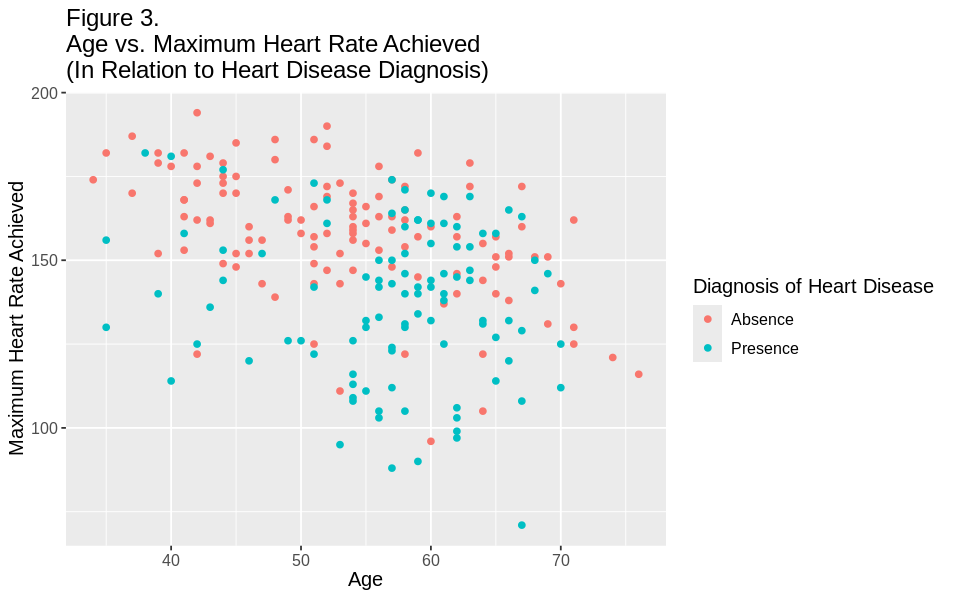

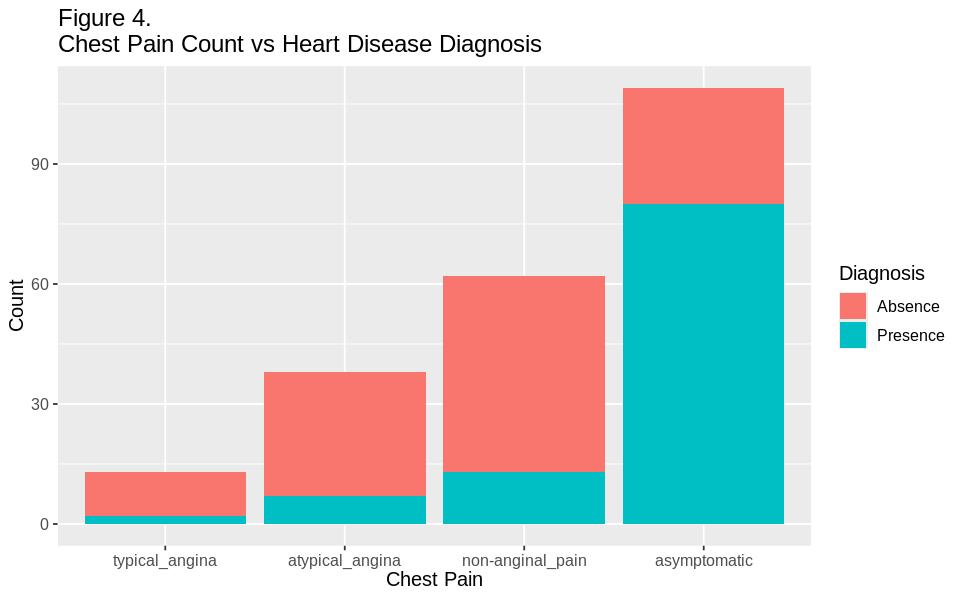

In [16]:
options(repr.plot.width = 8, repr.plot.height = 5)
viz_max <- data_train |>
    ggplot(aes(x = age, y = maximum_heart_rate_achieved,  colour = diagnosis_of_heart_disease)) +
    geom_point() +
    labs(title = "Figure 3. \nAge vs. Maximum Heart Rate Achieved \n(In Relation to Heart Disease Diagnosis)", x = "Age", y = "Maximum Heart Rate Achieved", colour = "Diagnosis of Heart Disease") +
    theme(text = element_text(size = 12))
viz_max

viz_chest <- data_train |>
    ggplot(aes(x = chest_pain, fill = diagnosis_of_heart_disease)) +
    geom_histogram(stat = "count") +
    labs(title = "Figure 4. \nChest Pain Count vs Heart Disease Diagnosis", x = "Chest Pain", fill = "Diagnosis", y = "Count") +
    theme(text = element_text(size = 12))
viz_chest

## Methods

To conduct my data analysis for this project, I will use the K-nearest neighbours classification algorithm. I will use the variables age, and maximum heart rate achieved, to predict a heart disease diagnosis (I have decided to exclude chest pain from the model as I have observed in Figure 4 that most observations with a presence of heart disease were asymptomatic for chest pain, and most observations with a absence of heart disease were symptomatic for chest pain. Therefore it appears to be an irrelevant predictor.). For the analysis I will first perform cross-validation on my training data set, to find the K value with the highest accuracy. After this, I will create a model and evaluate the estimated accuracy of the classifier on the test set using the predict function. To observe how well age, and maximum heart rate achieved, can be used to predict a diagnosis of heart disease. I will then visualize these results by using a confusion matrix, to show the model's accuracy, precision, and recall.

## Expected outcomes and significance


I expect to find that age, and maximum heart rate achieved will prove to be accurate when predicting a diagnosis of heart disease. Lauer et al. have shown that an impaired heart rate response has been associated with an increased risk of coronary heart disease (Lauer et al., 1996). Several other studies have also demonstrated an association between failure to achieve a predicted heart rate and coronary artery disease prognosis (Lauer et al., 1996). Therefore it seems logical that this correlation will be reflected in this project as well.

As for impact, I believe that if a strong correlation is observed between maximum heart rate achieved and heart disease diagnosis, it could help individuals be able to keep a better monitor of their own heart health. This project could also allow for a better understanding at which age, your potential for heart disease begins to increase. It will also be useful to spread awareness around the fact that most cases of heart disease are asymptomatic for chest pain.


## Data Analysis

Below I have created a model to test the hypothesis. I first created a recipe and knn spec to tune for the best K value, which was found to be 21. I have also created a visualization to represent the accuracy estimate vs. the various K values tested. 

[1] 21

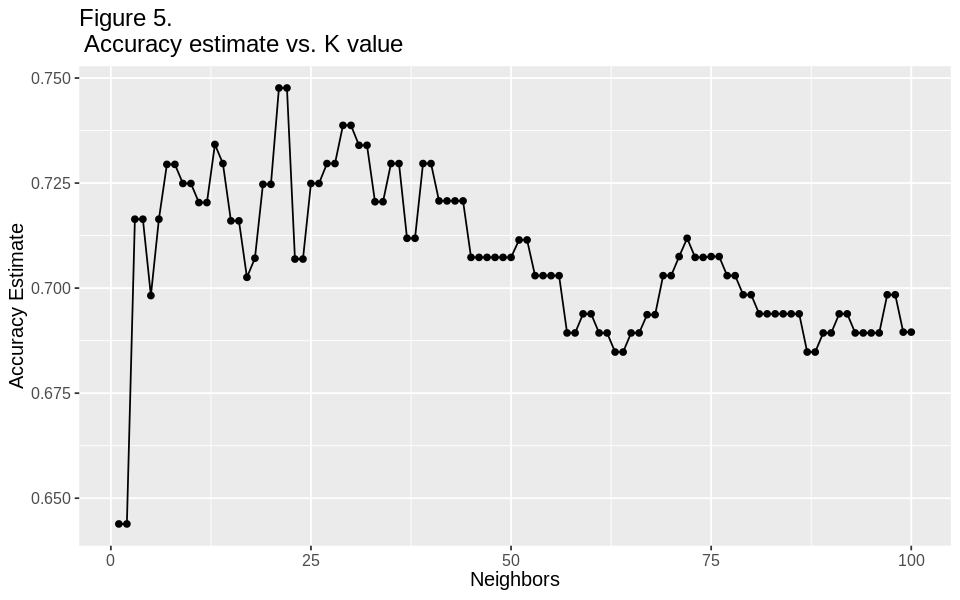

In [7]:
set.seed(2007)
k_lots <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

heart_recipe <- recipe(diagnosis_of_heart_disease ~ age +  maximum_heart_rate_achieved,
                        data = data_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_vfold <- vfold_cv(data_train, v = 10, strata = diagnosis_of_heart_disease)


heart_results <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heart_vfold, grid = k_lots) |>
  collect_metrics()

accuracies_lots <- heart_results |>
  filter(.metric == "accuracy")

accuracy_vs_k_lots <- ggplot(accuracies_lots, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(title = "Figure 5. \n Accuracy estimate vs. K value", x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))
accuracy_vs_k_lots

best_k <- accuracies_lots |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

Below I have inserted the best K value found above into the model spec, and trained the model. 

In [8]:
heart_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 21) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_best_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(heart_best_spec) |>
  fit(data = data_train)
heart_best_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(21,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2792793
Best kernel: rectangular
Best k: 21

Finally, I have now tested this model on the testing data, to calculate the accuracy, precision, and recall.

In [9]:
heart_test_predictions <- predict(heart_best_fit, data_test) |>
  bind_cols(data_test)

heart_test_predictions |> pull(diagnosis_of_heart_disease) |> levels()


[1] "Absence"  "Presence"

In [10]:
heart_test_predictions |>
  metrics(truth = diagnosis_of_heart_disease, estimate = .pred_class) |>
  filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6666667


#### Figure 6. Accuracy Estimate.

In [11]:
heart_test_predictions |>
    precision(truth = diagnosis_of_heart_disease, estimate = .pred_class, event_level="second")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.65625


#### Figure 7. Precision Estimate.

In [12]:
heart_test_predictions |>
    recall(truth = diagnosis_of_heart_disease, estimate = .pred_class, event_level="second")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.6


#### Figure 8. Recall Estimate.

In [13]:
confusion <- heart_test_predictions |>
             conf_mat(truth = diagnosis_of_heart_disease, estimate = .pred_class)
confusion

          Truth
Prediction Absence Presence
  Absence       29       14
  Presence      11       21

#### Figure 9. Confusion Matrix.

## Discussion

#### My Findings

I found that by using age, and maximum heart rate achieved, my model was able to achieve a 67% accuracy, 66% precision, and 60% recall. In this particular scenario, I believe the recall predictor to be the most important as it would be vital to predict the presence of heart disease correctly, and not accidently assign a new observation to have an absence of heart disease. Therefore I do not feel confident in this model due to the 60% recall metric. To improve upon this model, I believe other predictors could be used as well, specifically ones that show a strong relationship with heart disease. I also believe an increase in the amount of data used in the model could increase the reliability by increasing the sample size. Finally, I have also found through exploratory analysis alone, that chest pain seems to not be an indicator of chest disease, and should not be relied upon as a signal of such a presence.

#### Do my findings align with my expected findings

My findings do align with my expected findings, as age and maximum heart rate achieved do prove to be around 60% accurate when predicting a diagnosis of heart disease. Although I do believe these variables on their own turned out to be less accurate than expected in predicted heart disease. I believe the low accuracy can be attributed to the fact that heart rate is related to many factors besides age and the presence of heart disease. Other factors include sex, physical conditioning, sympathetic drive, baroreceptor reflexes, and venous return (Lauer et al., 1996). Therefore this model, having not included these variables, is bound to be far less accurate than one that had included them. 

#### Impact

I believe the impact of these findings has great significance, for small correlations can lead to the discovery of relations that will be able to predict heart disease with great accuracy. So although this model proved to boast a low accuracy and recall metric, that is not to say it will not lead to future models that could potentially save lives. As for chest pain, it has been previously expressed that a great impact could be generated from spreading awareness around the fact that most cases of heart disease are asymptomatic for chest pain, and to not rely on it as an indicator of such a disease.


#### Future Questions

As for future questions, I believe it essential to question if variables like sex, physical conditioning, sympathetic drive, baroreceptor reflexes, venous return, ST-segment response to exercise, baseline physical activity, and other traditional coronary disease risk factors can be incorporated into a model, to find a higher accuracy. I also think studies regarding chest pain's relation to heart disease should be questioned in greater detail, in order to see if there is truly any correlation and if not, to stop the spread of misinformation. 


## References

Janosi, Andras, Steinbrunn, William, Pfisterer, Matthias, and Detrano, Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

Lauer, M. S., Okin, P. M., Larson, M. G., Evans, J. C., & Levy, D. (1996). Impaired heart rate response to graded exercise. Circulation, 93(8), 1520–1526. https://doi.org/10.1161/01.cir.93.8.1520 

Mayo Foundation for Medical Education and Research. (2024, June 14). Coronary artery disease. Mayo Clinic. https://www.mayoclinic.org/diseases-conditions/coronary-artery-disease/symptoms-causes/syc-20350613#:~:text=CAD%20happens%20when%20coronary%20arteries,or%20even%20a%20heart%20attack. 